In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, f1_score, precision_score, recall_score
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

from xgboost import XGBClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression,LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score

Загрузить файл data_breast.csv. В данном файле собрана расчетная информация с обработанных изображений биоптата молочных желез женщин. Задача заключается в предсказании переменной “Diagnosis” - является ли содержимое биоптата доброкачественным (значение “B” – benign) либо злокачественным (значение “M” –malicious). Описание данных доступно на сайте

In [2]:
df=pd.read_csv(r'C:\Users\semen\Documents\netology\breast.csv')

Ten real-valued features are computed for each cell nucleus: 

a) radius (mean of distances from center to points on the perimeter) 
b) texture (standard deviation of gray-scale values) 
c) perimeter 
d) area 
e) smoothness (local variation in radius lengths) 
f) compactness (perimeter^2 / area - 1.0) 
g) concavity (severity of concave portions of the contour) 
h) concave points (number of concave portions of the contour) 
i) symmetry 
j) fractal dimension ("coastline approximation" - 1)

Рассчитать основные статистики для переменных (среднее, медиана, мода, мин/макс, сред. отклонение).

In [10]:
df.describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,0.0
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,NaN
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,NaN
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,NaN
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,NaN
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,NaN
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,NaN
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,NaN


Выбрать стратегию для работы с пропущенными значениями.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
id                         569 non-null int64
diagnosis                  569 non-null object
radius_mean                569 non-null float64
texture_mean               569 non-null float64
perimeter_mean             569 non-null float64
area_mean                  569 non-null float64
smoothness_mean            569 non-null float64
compactness_mean           569 non-null float64
concavity_mean             569 non-null float64
concave points_mean        569 non-null float64
symmetry_mean              569 non-null float64
fractal_dimension_mean     569 non-null float64
radius_se                  569 non-null float64
texture_se                 569 non-null float64
perimeter_se               569 non-null float64
area_se                    569 non-null float64
smoothness_se              569 non-null float64
compactness_se             569 non-null float64
concavity_se               569 non

In [12]:
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [3]:
# заменим  "М" на 1, a "В" на 0
df.diagnosis.replace(['M', 'B'], [1, 0], inplace=True)

In [4]:
#Столбец Unnamed: 32, где все значения пустые удаляю
del df['Unnamed: 32']

In [7]:
#перевернем датасет и посмотрим на все столбцы
random = df.take(np.random.permutation(len(df))[:7])
random.T

,490,355,392,209,431,274,339
id,9.137670e+07,9.010258e+06,903507.000000,8.810436e+06,907915.000000,8.911163e+06,89812.000000
diagnosis,0.000000e+00,0.000000e+00,1.000000,0.000000e+00,0.000000,1.000000e+00,1.000000
radius_mean,1.225000e+01,1.256000e+01,15.490000,1.527000e+01,12.400000,1.793000e+01,23.510000
texture_mean,2.244000e+01,1.907000e+01,19.970000,1.291000e+01,17.680000,2.448000e+01,24.270000
perimeter_mean,7.818000e+01,8.192000e+01,102.400000,9.817000e+01,81.470000,1.152000e+02,155.100000
area_mean,4.665000e+02,4.858000e+02,744.700000,7.255000e+02,467.800000,9.989000e+02,1747.000000
smoothness_mean,8.192000e-02,8.760000e-02,0.116000,8.182000e-02,0.105400,8.855000e-02,0.106900
compactness_mean,5.200000e-02,1.038000e-01,0.156200,6.230000e-02,0.131600,7.027000e-02,0.128300
concavity_mean,1.714000e-02,1.030000e-01,0.189100,5.892000e-02,0.077410,5.699000e-02,0.230800
concave points_mean,1.261000e-02,4.391000e-02,0.091130,3.157000e-02,0.027990,4.744000e-02,0.141000


Рассчитать и визуализировать корреляционную матрицу для переменных.
Визуализировать взаимосвязи между переменными (scatter plots, гистограммы, …).
С помощью статистических методов проверить взаимосвязи между переменными.

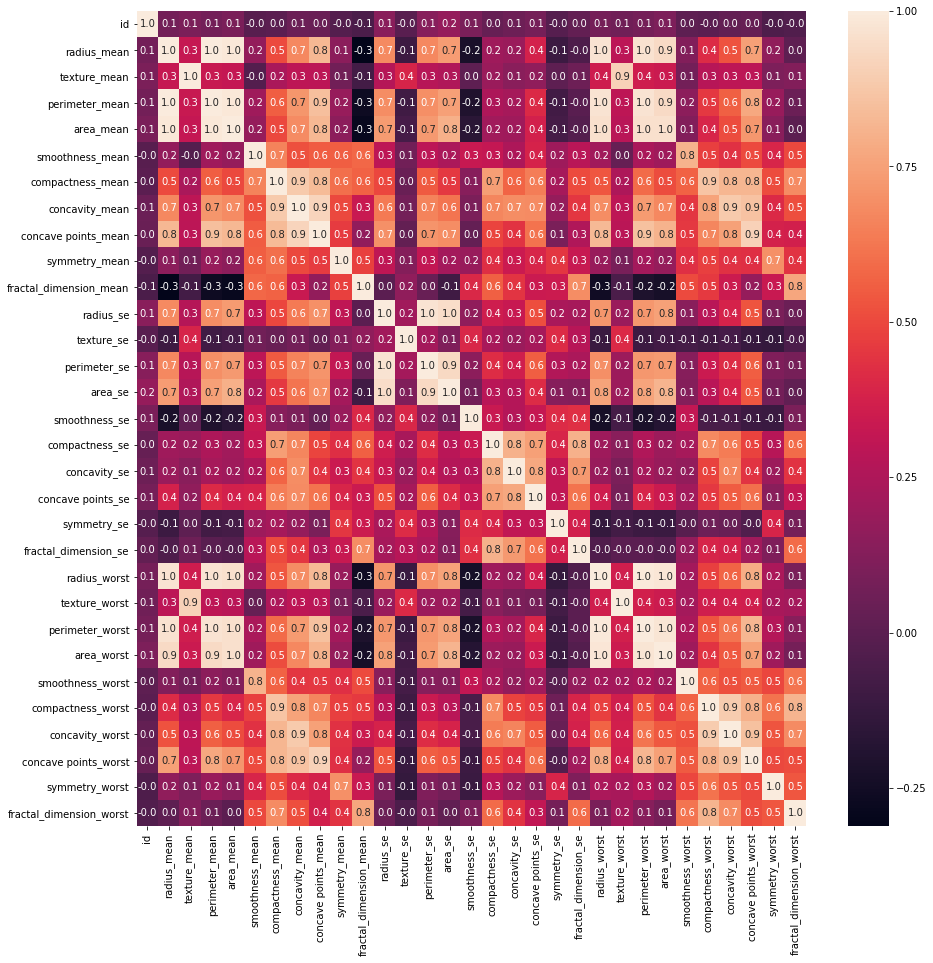

In [16]:
import matplotlib.pyplot as plt
correlation=df.corr()
fig, ax = plt.subplots(figsize=(15,15))  
sns.heatmap(correlation,annot=True,fmt= '.1f',ax=ax)

Выбрать стратегию Feature Selection – сокращение размерности либо генерация новых переменных. Какой из этих двух подходов даст лучший результат при классификации?

C:\Users\semen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\semen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Text(0, 0.5, 'explained_variance_ratio_')

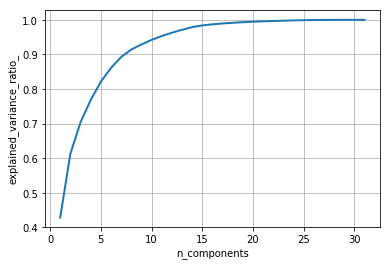

In [5]:
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']
scaler = StandardScaler()
pca = PCA().fit(scaler.fit_transform(X))
cum_evr = np.cumsum(pca.explained_variance_ratio_)
xs = np.arange(cum_evr.size) + 1
plt.plot(xs, cum_evr, linewidth=2)
plt.grid()
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_')

In [ ]:
#12 из 30 фичей объясняют 95%. нужно сокращать размерность

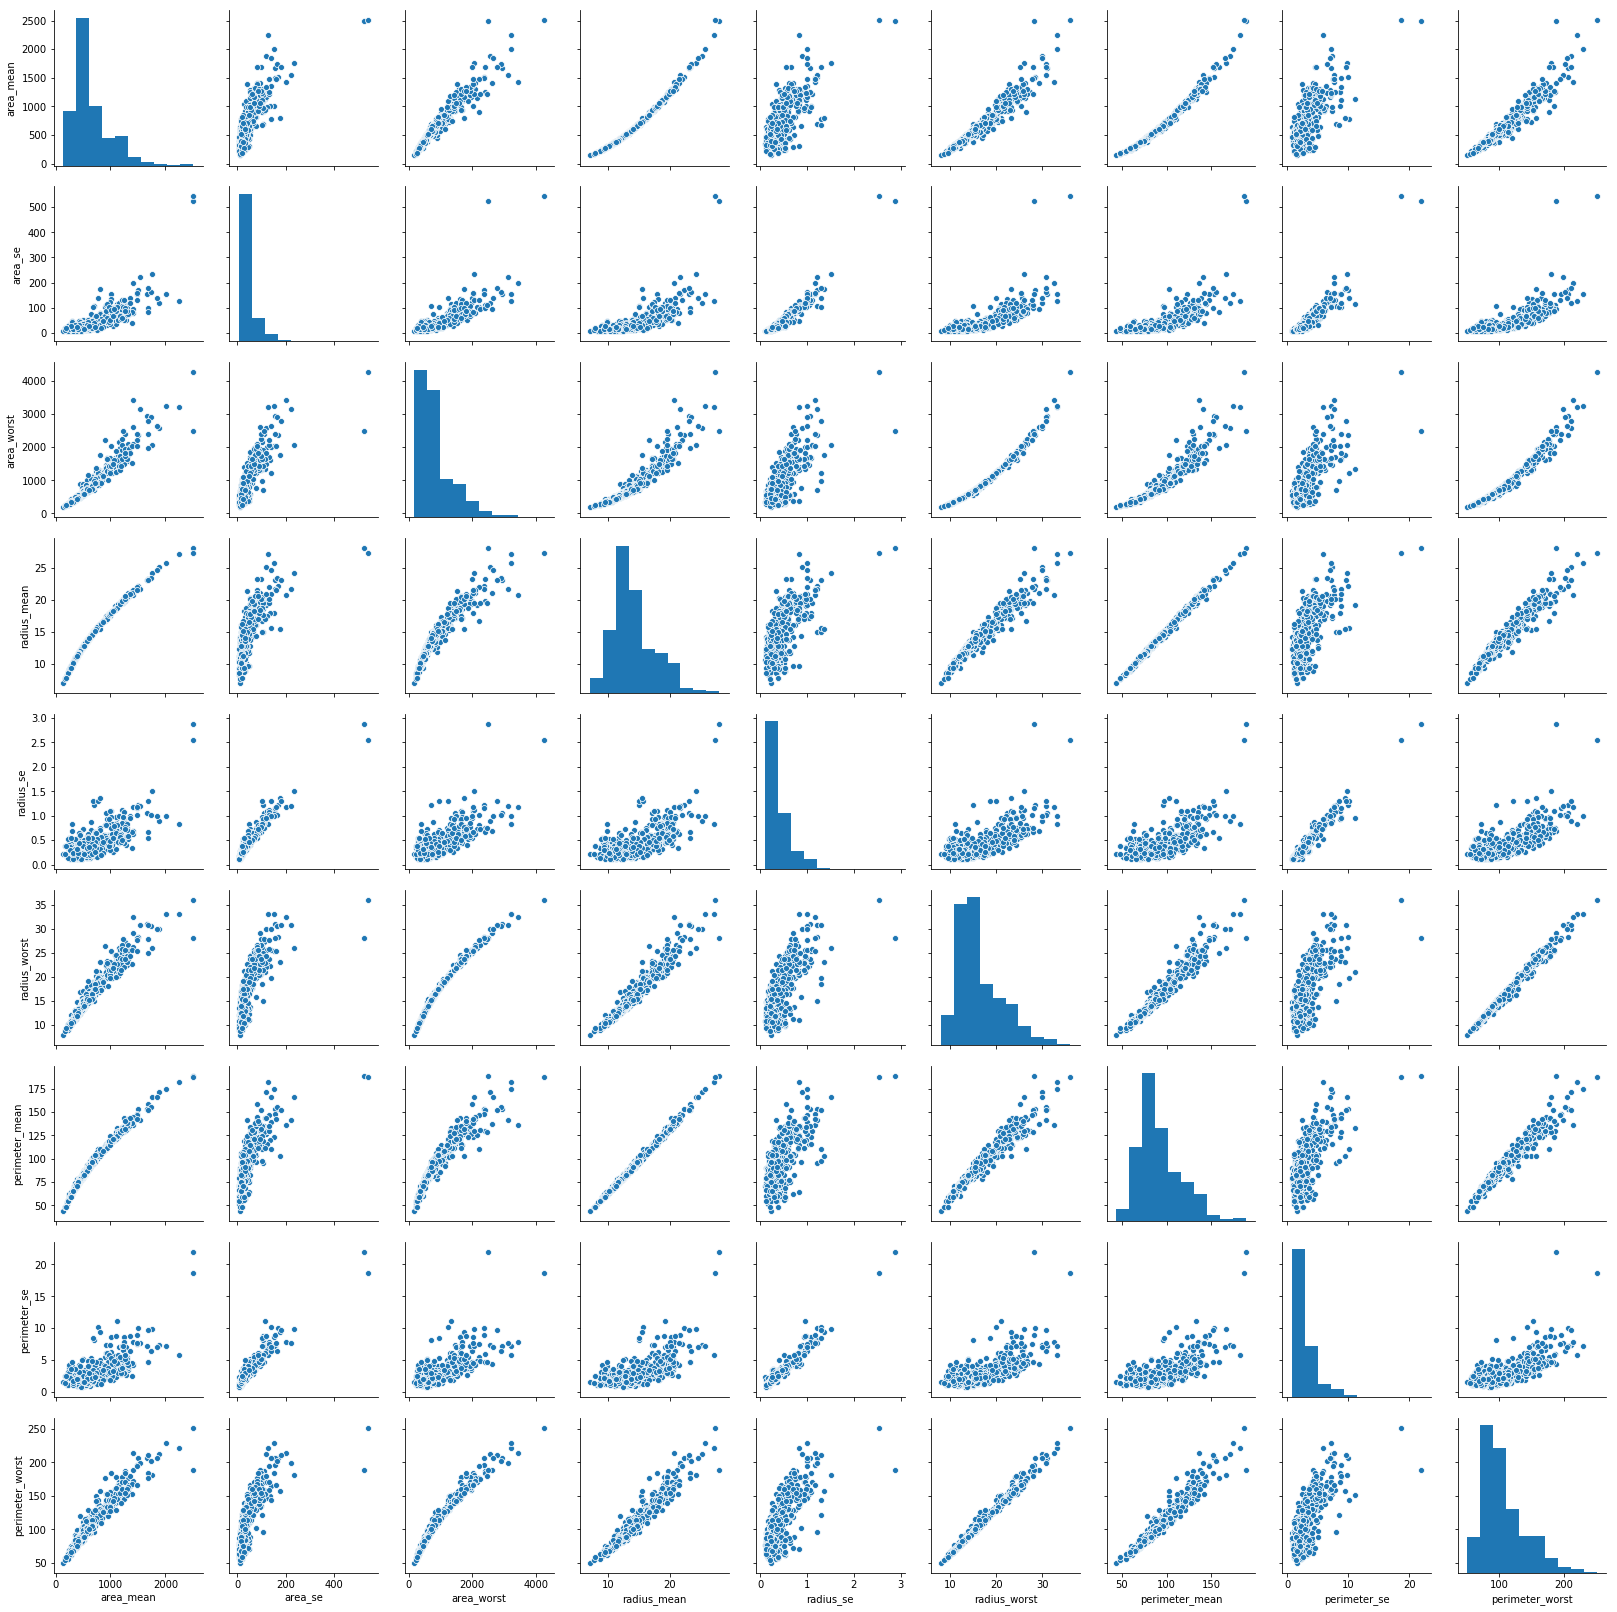

In [10]:
# логически понятно, что  площадь, периметр и радиус это одинаковые переменные. проверим:

columns=[x for x in df.columns if 'area' in x] + [x for x in df.columns if 'radius' in x] + [x for x in df.columns if 'perimeter' in x]

sns.pairplot(df, vars=columns)

In [11]:
# таким образом можно оставить только радиус, также видно, 
#что характеристики площади se и wost имеют коэффицент корреляции 0,96
# Оставляем только 1


In [5]:
#Список фичей от которых избавляемся
drop_list = ['id','radius_worst','area_mean', 'area_se', 'area_worst','perimeter_mean', 'perimeter_se', 'perimeter_worst']


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000026BDC0F67F0>,
      dtype=object)

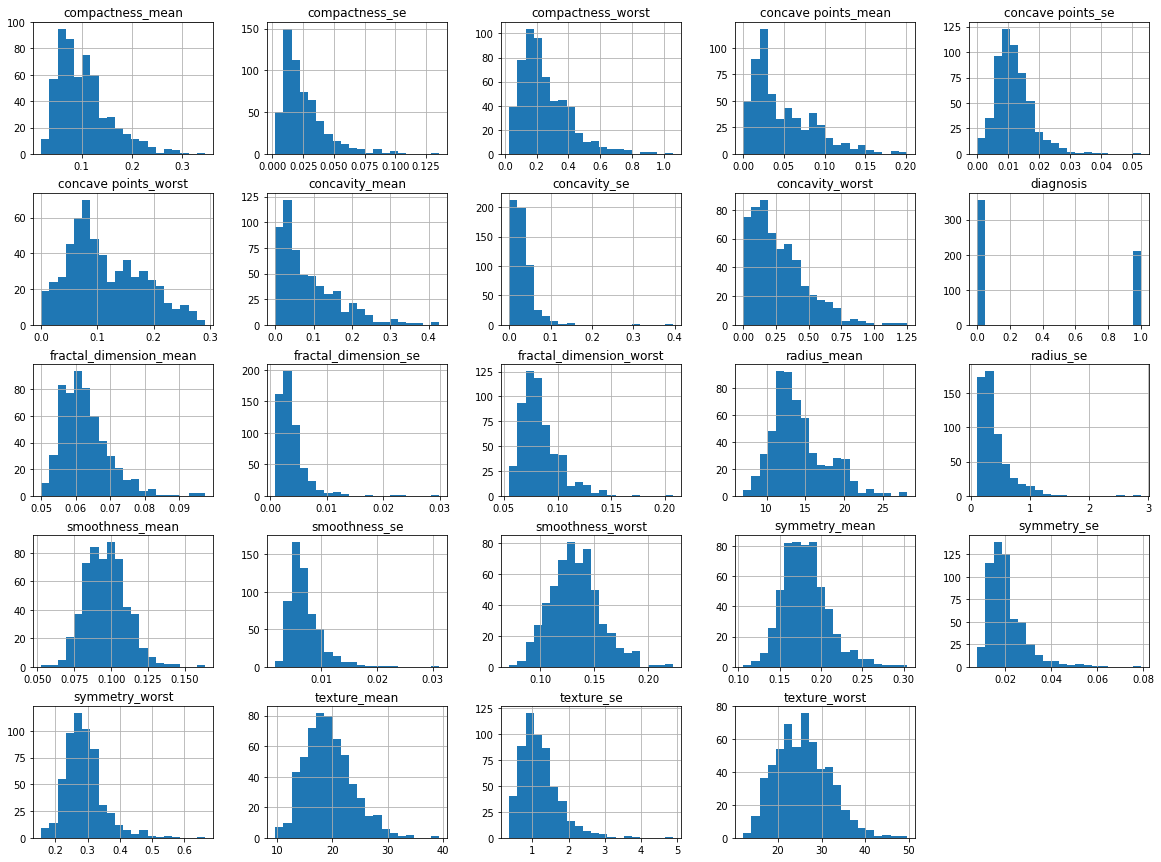

In [12]:
df.drop(drop_list,axis=1).hist(bins = 20, figsize=(20,15))


Рассчитать Feature Selection для выбранных переменных.

Решить задачу бинарной классификации и предсказать переменную ”Diagnosis ” протестировав как минимум 2 алгоритма. Использовать те алгоритмы, которые позволяют предсказать вероятность класса (proba). Рассчитать и вывести вероятность каждого класса.
Проверить качество классификации с использованием следующих метрик: Accuracy, F1-Score, Precision, Recall

In [6]:

X = df.drop(drop_list,axis=1).iloc[:,1:]
y = df['diagnosis']

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state=101)

In [10]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

def get_formula(_cols):
    return 'diagnosis ~ ' + " + ".join(_cols)

_iteration_cols = X_train.columns

columns = np.append(_iteration_cols,'diagnosis')

train_df = pd.DataFrame(np.c_[X_train, y_train], columns=columns)
get_formula(_iteration_cols)

lm = smf.ols(get_formula(_iteration_cols), train_df).fit()
rss = np.sum(lm.resid ** 2)
rmse = np.sqrt(rss / len(lm.resid))
print("RMSE:", rmse)
print("R^2:", lm.rsquared)

lm_res_0 = lm.summary()
lm_res_0.tables[1]

SyntaxError: invalid syntax (<unknown>, line 1)

In [8]:
#Логистическая регрессия 

logModel = LogisticRegression()
logModel.fit(X, y)

y_train_predict = logModel.predict(X_train)
y_test_predict = logModel.predict(X_test)

accuracy = np.round(accuracy_score(y_test, y_test_predict.round()),2)
f1 = np.round(f1_score(y_test, y_test_predict.round()),2)
presicion = np.round(precision_score(y_test, y_test_predict.round()),2)
recall = np.round(recall_score(y_test, y_test_predict.round()),2)

print("Accuracy:" , accuracy)
print("F1-score:" , f1)
print("Precision_score:" , presicion)
print("Recall_score:" , recall)

Accuracy: 0.94
F1-score: 0.92
Precision_score: 0.98
Recall_score: 0.86


C:\Users\semen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [ ]:
#xgboost падает с пометкой Dead Kernel ничего не помогает

xgb = XGBClassifier(max_depth=4, n_jobs=-1)
xgb.fit(X_train, y_train)
y_train_predict = xgb.predict_proba(X_train)[:, 1]
y_test_predict = xgb.predict_proba(x_test)[:, 1]

accuracy = np.round(accuracy_score(y_test, y_test_predict.round()),2)
f1 = np.round(f1_score(y_test, y_test_predict.round()),2)
presicion = np.round(precision_score(y_test, y_test_predict.round()),2)
recall = np.round(recall_score(y_test, y_test_predict.round()),2)

print("Accuracy:" , accuracy)
print("F1-score:" , f1)
print("Precision_score:" , presicion)
print("Recall_score:" , recall)

In [9]:
#Random Forest
rfc = RandomForestClassifier(n_estimators=10, max_depth=10)

rfc.fit(X_train, y_train)
y_train_predict = rfc.predict_proba(X_train)[:, 1]
y_test_predict = rfc.predict_proba(X_test)[:, 1]

accuracy = np.round(accuracy_score(y_test, y_test_predict.round()),2)
f1 = np.round(f1_score(y_test, y_test_predict.round()),2)
presicion = np.round(precision_score(y_test, y_test_predict.round()),2)
recall = np.round(recall_score(y_test, y_test_predict.round()),2)

print("Accuracy:" , accuracy)
print("F1-score:" , f1)
print("Precision_score:" , presicion)
print("Recall_score:" , recall)

Accuracy: 0.92
F1-score: 0.9
Precision_score: 0.93
Recall_score: 0.86
